## Importaciones y Configuración Inicial

In [2]:
import numpy as np
import pandas as pd
import time
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    average_precision_score, precision_recall_curve
)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, LSTM

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

2025-10-23 21:11:37.776481: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## CARGA Y PREPARACIÓN DE DATOS

In [3]:
def load_cleaned_dataset():
    CLEANED_DATASET_PATH = "../data/processed/ddos_final.csv"
    
    try:
        df_cleaned = pd.read_csv(CLEANED_DATASET_PATH)
        return df_cleaned
    except FileNotFoundError:
        exit()
    except Exception as e:
        exit()

# Carga y preparación de datos
df = load_cleaned_dataset()

In [4]:
if 'y' not in df.columns:
    print("Columna objetivo 'y' no encontrada")
    exit()

In [5]:
# Separar características y objetivo
feature_cols = [col for col in df.columns if col != 'y']
X = df[feature_cols].values
y = df['y'].values.astype(int)

print(f"Características: {X.shape[1]} variables")
print(f"Distribución de clases: {np.bincount(y)}")
print(f"   - BENIGN: {np.bincount(y)[0]:,} muestras")
print(f"   - ATTACK: {np.bincount(y)[1]:,} muestras")

Características: 19 variables
Distribución de clases: [2112318  558161]
   - BENIGN: 2,112,318 muestras
   - ATTACK: 558,161 muestras


### División y Escalado de Datos

In [6]:
# División estratificada para mantener la proporción de clases
X_train_raw, X_temp_raw, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val_raw, X_test_raw, y_val, y_test = train_test_split(
    X_temp_raw, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

In [7]:
# Escalado sin leakage
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)

input_dim = X_train.shape[1]

print(f"Datos divididos y escalados:")
print(f"   Train: {X_train.shape[0]:,} muestras")
print(f"   Val:   {X_val.shape[0]:,} muestras")
print(f"   Test:  {X_test.shape[0]:,} muestras")

Datos divididos y escalados:
   Train: 1,869,335 muestras
   Val:   400,572 muestras
   Test:  400,572 muestras


## LÍNEA BASE (BASELINE)

In [8]:
# Entrenamiento del modelo baseline
start_time = time.time()
baseline_model = LogisticRegression(
    random_state=42,
    class_weight='balanced',
    solver='lbfgs',
    max_iter=1000,
    n_jobs=-1
)
baseline_model.fit(X_train, y_train)
train_time_base = time.time() - start_time

In [9]:
# Evaluación
start_inf = time.time()
y_prob_base = baseline_model.predict_proba(X_test)[:, 1]
inf_time_base = (time.time() - start_inf) / len(X_test)
y_pred_base = (y_prob_base >= 0.5).astype(int)

In [10]:
# Métricas
report_base = classification_report(y_test, y_pred_base, output_dict=True, zero_division=0)
roc_auc_base = roc_auc_score(y_test, y_prob_base)
pr_auc_base = average_precision_score(y_test, y_prob_base)
precision_base, recall_base, _ = precision_recall_curve(y_test, y_prob_base)

print("Línea Base completada")
print(f"Tiempo entrenamiento: {train_time_base:.1f}s")
print(f"Latencia inferencia: {inf_time_base*1e6:.1f}µs/muestra")

Línea Base completada
Tiempo entrenamiento: 8.3s
Latencia inferencia: 0.1µs/muestra


## EXPERIMENTOS A/B (VARIANTE 1)

In [11]:
# Configuración común
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

In [12]:
# Callbacks
early_stop = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(patience=5, factor=0.5, verbose=0)

### VARIANTE 1: AUTOENCODER + CNN-LSTM

In [13]:
# Autoencoder
def build_autoencoder(input_dim, encoding_dim=32):
    inputs = layers.Input(shape=(input_dim,))
    
    # Encoder
    encoded = layers.Dense(256, activation='relu')(inputs)
    encoded = layers.Dense(128, activation='relu')(encoded)
    encoded = layers.Dense(64, activation='relu')(encoded)
    bottleneck = layers.Dense(encoding_dim, activation='relu', name='bottleneck')(encoded)
    
    # Decoder
    decoded = layers.Dense(64, activation='relu')(bottleneck)
    decoded = layers.Dense(128, activation='relu')(decoded)
    decoded = layers.Dense(256, activation='relu')(decoded)
    decoded = layers.Dense(input_dim, activation='linear')(decoded)
    
    autoencoder = models.Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

In [14]:
# Entrenamiento Autoencoder
autoencoder = build_autoencoder(input_dim)
start_time = time.time()
history_ae = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=10, batch_size=512, 
    callbacks=[early_stop], verbose=1
)
train_time_ae = time.time() - start_time

Epoch 1/10
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0091 - val_loss: 0.0018
Epoch 2/10
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0011 - val_loss: 6.4888e-04
Epoch 3/10
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 7.1146e-04 - val_loss: 2.9551e-04
Epoch 4/10
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 5.5403e-04 - val_loss: 0.0032
Epoch 5/10
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 4.9871e-04 - val_loss: 3.1506e-04
Epoch 6/10
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 4.5143e-04 - val_loss: 0.0011
Epoch 7/10
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 4.0325e-04 - val_loss: 0.0069
Epoch 8/10
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 3.9394e-04 - val_loss: 3.5628e-04
Epoch 9/10
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 3.4352e-04 - val_loss: 0.0023
Epoch 10/10
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 3.5439e-04 - val_loss: 4.7982e-04


In [15]:
# Extracción de características
encoder = models.Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
Z_train = encoder.predict(X_train, verbose=1)
Z_val = encoder.predict(X_val, verbose=1)
Z_test = encoder.predict(X_test, verbose=1)

58417/58417 ━━━━━━━━━━━━━━━━━━━━ 32s 547us/step
12518/12518 ━━━━━━━━━━━━━━━━━━━━ 7s 528us/step
12518/12518 ━━━━━━━━━━━━━━━━━━━━ 7s 532us/step


In [16]:
# Preparación secuencial
def to_sequential_format(arr):
    return arr.reshape((arr.shape[0], arr.shape[1], 1))

Z_train_seq = to_sequential_format(Z_train)
Z_val_seq = to_sequential_format(Z_val)
Z_test_seq = to_sequential_format(Z_test)

In [17]:
# Modelo CNN-LSTM
def build_cnn_lstm(seq_length):
    model = Sequential([
        Conv1D(64, 3, activation='relu', padding='same', input_shape=(seq_length, 1)),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu', padding='same'),
        Dropout(0.3),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [19]:
# Entrenamiento CNN-LSTM
cnn_lstm_model = build_cnn_lstm(Z_train_seq.shape[1])
start_time = time.time()
history_clf = cnn_lstm_model.fit(
    Z_train_seq, y_train,
    validation_data=(Z_val_seq, y_val),
    epochs=5, batch_size=512,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
train_time_clf = time.time() - start_time

Epoch 1/5
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 153s 41ms/step - accuracy: 0.6248 - loss: 0.6405 - val_accuracy: 0.6208 - val_loss: 0.6474 - learning_rate: 0.0010
Epoch 2/5
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 156s 43ms/step - accuracy: 0.6345 - loss: 0.6325 - val_accuracy: 0.6311 - val_loss: 0.6475 - learning_rate: 0.0010
Epoch 3/5
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 157s 43ms/step - accuracy: 0.6379 - loss: 0.6306 - val_accuracy: 0.6399 - val_loss: 0.6372 - learning_rate: 0.0010
Epoch 4/5
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 158s 43ms/step - accuracy: 0.6354 - loss: 0.6294 - val_accuracy: 0.6088 - val_loss: 0.6576 - learning_rate: 0.0010
Epoch 5/5
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 158s 43ms/step - accuracy: 0.6376 - loss: 0.6287 - val_accuracy: 0.6352 - val_loss: 0.6204 - learning_rate: 0.0010


In [21]:
# Evaluación Variante 1
start_inf = time.time()
y_prob_var1 = cnn_lstm_model.predict(Z_test_seq, verbose=1).ravel()
inf_time_var1 = (time.time() - start_inf) / len(Z_test_seq)
y_pred_var1 = (y_prob_var1 >= 0.5).astype(int)

report_var1 = classification_report(y_test, y_pred_var1, output_dict=True, zero_division=0)
roc_auc_var1 = roc_auc_score(y_test, y_prob_var1)
pr_auc_var1 = average_precision_score(y_test, y_prob_var1)
precision_var1, recall_var1, _ = precision_recall_curve(y_test, y_prob_var1)

train_time_var1 = train_time_ae + train_time_clf

print("Variante 1 completada")
print(f"Tiempo total: {train_time_var1:.1f}s")
print(f"Latencia: {inf_time_var1*1e6:.1f}µs/muestra")

12518/12518 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step
Variante 1 completada
Tiempo total: 909.3s
Latencia: 71.1µs/muestra


### VARIANTE 2: MULTI-LAYER PERCEPTRON (MLP)

In [22]:
def build_mlp(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [24]:
# Entrenamiento MLP
mlp_model = build_mlp(input_dim)
start_time = time.time()
history_mlp = mlp_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10, batch_size=512,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
train_time_var2 = time.time() - start_time

Epoch 1/10
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6283 - loss: 0.6340 - val_accuracy: 0.6485 - val_loss: 0.6142 - learning_rate: 0.0010
Epoch 2/10
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6393 - loss: 0.6244 - val_accuracy: 0.6493 - val_loss: 0.6166 - learning_rate: 0.0010
Epoch 3/10
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6428 - loss: 0.6215 - val_accuracy: 0.6655 - val_loss: 0.5986 - learning_rate: 0.0010
Epoch 4/10
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6457 - loss: 0.6201 - val_accuracy: 0.6428 - val_loss: 0.6266 - learning_rate: 0.0010
Epoch 5/10
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6460 - loss: 0.6193 - val_accuracy: 0.6700 - val_loss: 0.5965 - learning_rate: 0.0010
Epoch 6/10
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6470 - loss: 0.6188 - val_accuracy: 0.6432 - val_loss: 0.6178 - learning_rate: 0.0010
Epoch 7/10
3652/3652 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6465 - l

In [25]:
# Evaluación Variante 2
start_inf = time.time()
y_prob_var2 = mlp_model.predict(X_test, verbose=1).ravel()
inf_time_var2 = (time.time() - start_inf) / len(X_test)
y_pred_var2 = (y_prob_var2 >= 0.5).astype(int)

report_var2 = classification_report(y_test, y_pred_var2, output_dict=True, zero_division=0)
roc_auc_var2 = roc_auc_score(y_test, y_prob_var2)
pr_auc_var2 = average_precision_score(y_test, y_prob_var2)
precision_var2, recall_var2, _ = precision_recall_curve(y_test, y_prob_var2)

print("Variante 2 completada")
print(f"Tiempo: {train_time_var2:.1f}s")
print(f"Latencia: {inf_time_var2*1e6:.1f}µs/muestra")

12518/12518 ━━━━━━━━━━━━━━━━━━━━ 6s 507us/step
Variante 2 completada
Tiempo: 83.7s
Latencia: 23.8µs/muestra


## RESULTADOS Y VISUALIZACIÓN

### Tabla Comparativa: Baseline vs. Variante 1

In [26]:
# Tabla comparativa
results_data = {
    'Métrica': [
        'F1-Score (ATTACK) - Principal',
        'Precision (ATTACK)',
        'Recall (ATTACK)', 
        'Accuracy',
        'PR-AUC - Secundaria',
        'ROC-AUC',
        'Tiempo Entrenamiento (s)',
        'Latencia Inferencia (µs/muestra)'
    ],
    'Línea Base (Regresión Logística)': [
        f"{report_base['1']['f1-score']:.4f}",
        f"{report_base['1']['precision']:.4f}",
        f"{report_base['1']['recall']:.4f}",
        f"{report_base['accuracy']:.4f}",
        f"{pr_auc_base:.4f}",
        f"{roc_auc_base:.4f}",
        f"{train_time_base:.1f}",
        f"{inf_time_base*1e6:.1f}"
    ],
    'Variante 1 (AE + CNN-LSTM)': [
        f"{report_var1['1']['f1-score']:.4f}",
        f"{report_var1['1']['precision']:.4f}",
        f"{report_var1['1']['recall']:.4f}",
        f"{report_var1['accuracy']:.4f}",
        f"{pr_auc_var1:.4f}",
        f"{roc_auc_var1:.4f}",
        f"{train_time_var1:.1f}",
        f"{inf_time_var1*1e6:.1f}"
    ],
    'Variante 2 (MLP)': [
        f"{report_var2['1']['f1-score']:.4f}",
        f"{report_var2['1']['precision']:.4f}",
        f"{report_var2['1']['recall']:.4f}",
        f"{report_var2['accuracy']:.4f}",
        f"{pr_auc_var2:.4f}",
        f"{roc_auc_var2:.4f}",
        f"{train_time_var2:.1f}",
        f"{inf_time_var2*1e6:.1f}"
    ]
}

df_results = pd.DataFrame(results_data)
print("\n📋 TABLA COMPARATIVA")
print("="*80)
print(df_results.to_string(index=False))
print("="*80)


📋 TABLA COMPARATIVA
                         Métrica Línea Base (Regresión Logística) Variante 1 (AE + CNN-LSTM) Variante 2 (MLP)
   F1-Score (ATTACK) - Principal                           0.4166                     0.4296           0.4399
              Precision (ATTACK)                           0.3135                     0.3133           0.3300
                 Recall (ATTACK)                           0.6207                     0.6828           0.6596
                        Accuracy                           0.6366                     0.6210           0.6489
             PR-AUC - Secundaria                           0.3604                     0.3812           0.3943
                         ROC-AUC                           0.6825                     0.7000           0.7112
        Tiempo Entrenamiento (s)                              8.3                      909.3             83.7
Latencia Inferencia (µs/muestra)                              0.1                       71.1       

### Gráfico Único: Curva Precision-Recall

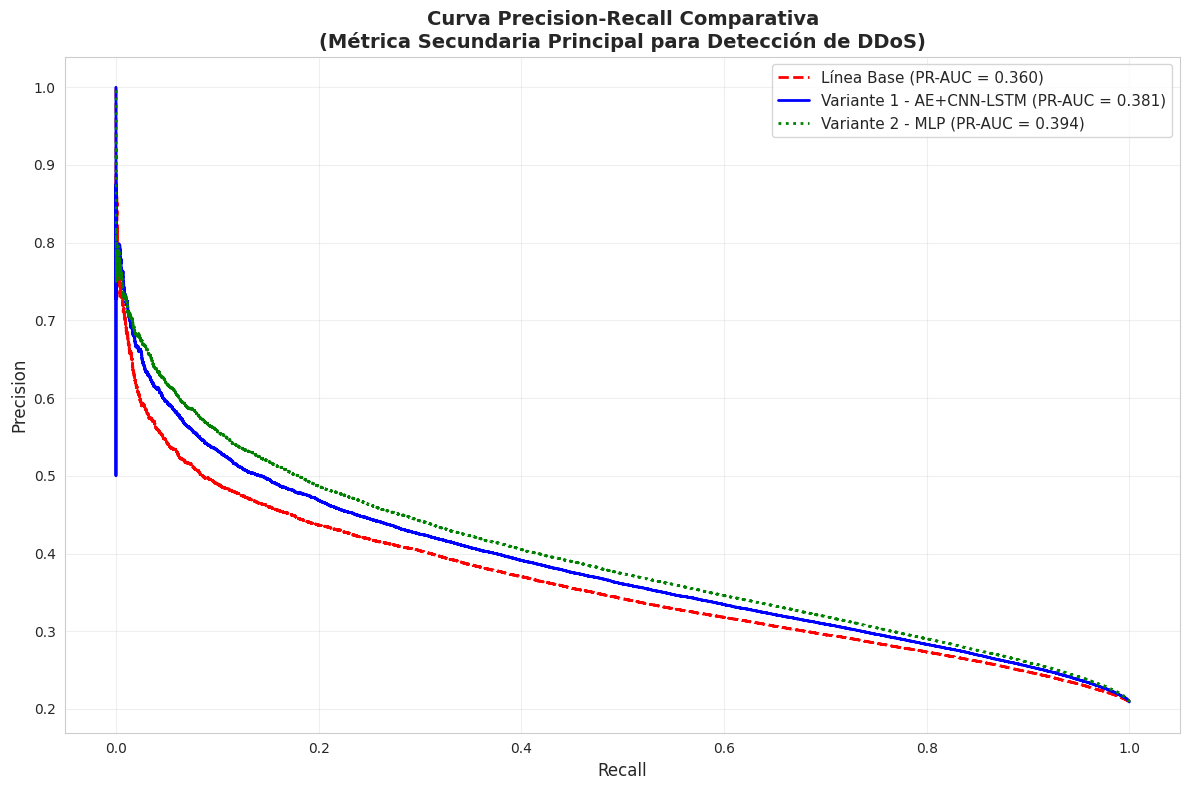

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(recall_base, precision_base, 
         label=f'Línea Base (PR-AUC = {pr_auc_base:.3f})', 
         color='red', linewidth=2, linestyle='--')
plt.plot(recall_var1, precision_var1, 
         label=f'Variante 1 - AE+CNN-LSTM (PR-AUC = {pr_auc_var1:.3f})', 
         color='blue', linewidth=2)
plt.plot(recall_var2, precision_var2, 
         label=f'Variante 2 - MLP (PR-AUC = {pr_auc_var2:.3f})', 
         color='green', linewidth=2, linestyle=':')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Curva Precision-Recall Comparativa\n(Métrica Secundaria Principal para Detección de DDoS)', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

TRADEOFF PRECISION-RECALL CON PUNTOS DE OPERACIÓN

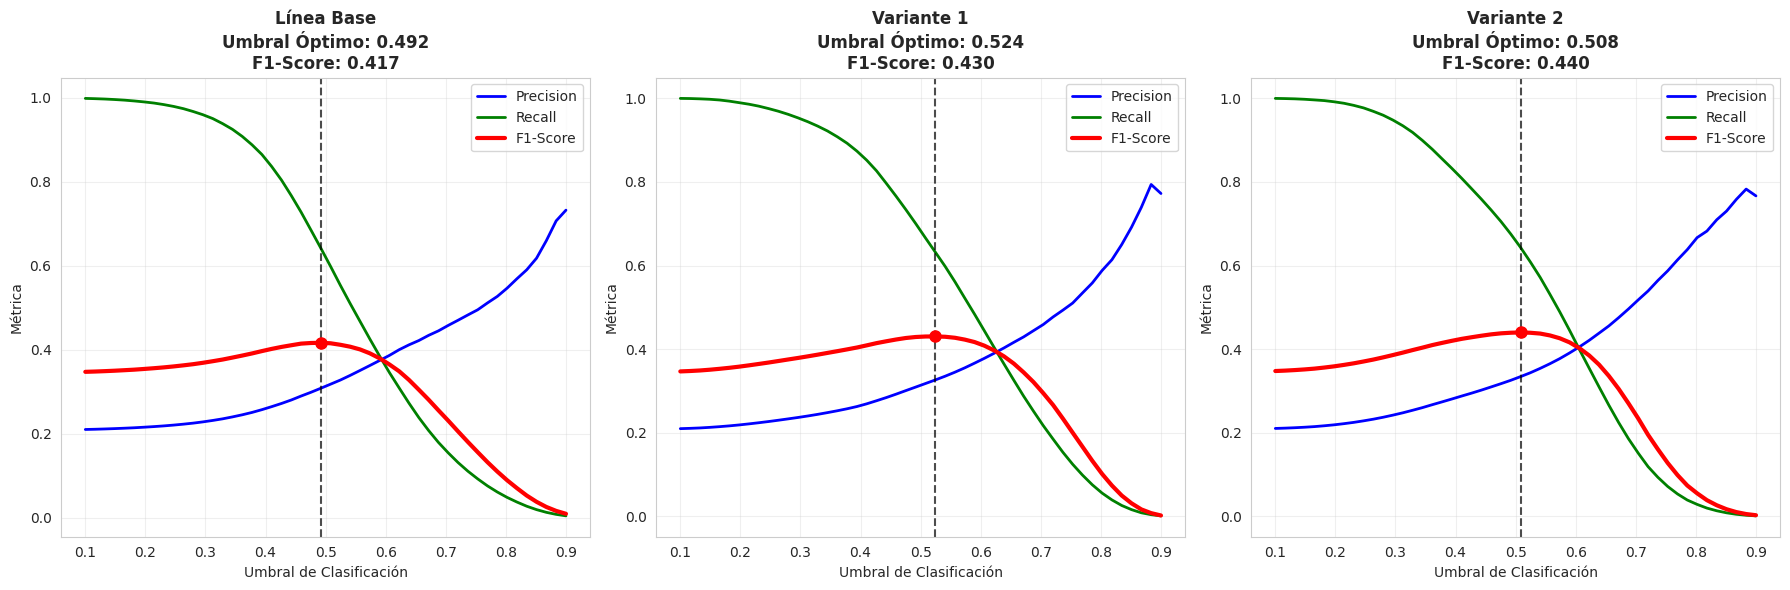

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (probs, model_name, color) in enumerate([
    (y_prob_base, 'Línea Base', 'red'),
    (y_prob_var1, 'Variante 1', 'blue'),
    (y_prob_var2, 'Variante 2', 'green')
]):
    # Calcular métricas para diferentes umbrales
    thresholds = np.linspace(0.1, 0.9, 50)
    precisions = []
    recalls = []
    f1_scores = []
    
    for threshold in thresholds:
        y_pred = (probs >= threshold).astype(int)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        precisions.append(report['1']['precision'])
        recalls.append(report['1']['recall'])
        f1_scores.append(report['1']['f1-score'])
    
    # Encontrar umbral óptimo (max F1)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    # Graficar
    axes[idx].plot(thresholds, precisions, 'b-', label='Precision', linewidth=2)
    axes[idx].plot(thresholds, recalls, 'g-', label='Recall', linewidth=2)
    axes[idx].plot(thresholds, f1_scores, 'r-', label='F1-Score', linewidth=3)
    
    # Marcar punto óptimo
    axes[idx].axvline(x=optimal_threshold, color='black', linestyle='--', alpha=0.7)
    axes[idx].plot(optimal_threshold, f1_scores[optimal_idx], 'ro', markersize=8)
    
    axes[idx].set_xlabel('Umbral de Clasificación')
    axes[idx].set_ylabel('Métrica')
    axes[idx].set_title(f'{model_name}\nUmbral Óptimo: {optimal_threshold:.3f}\nF1-Score: {f1_scores[optimal_idx]:.3f}', 
                       fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

COMPARACIÓN DE DETECCIÓN TEMPRANA (Recall@K)

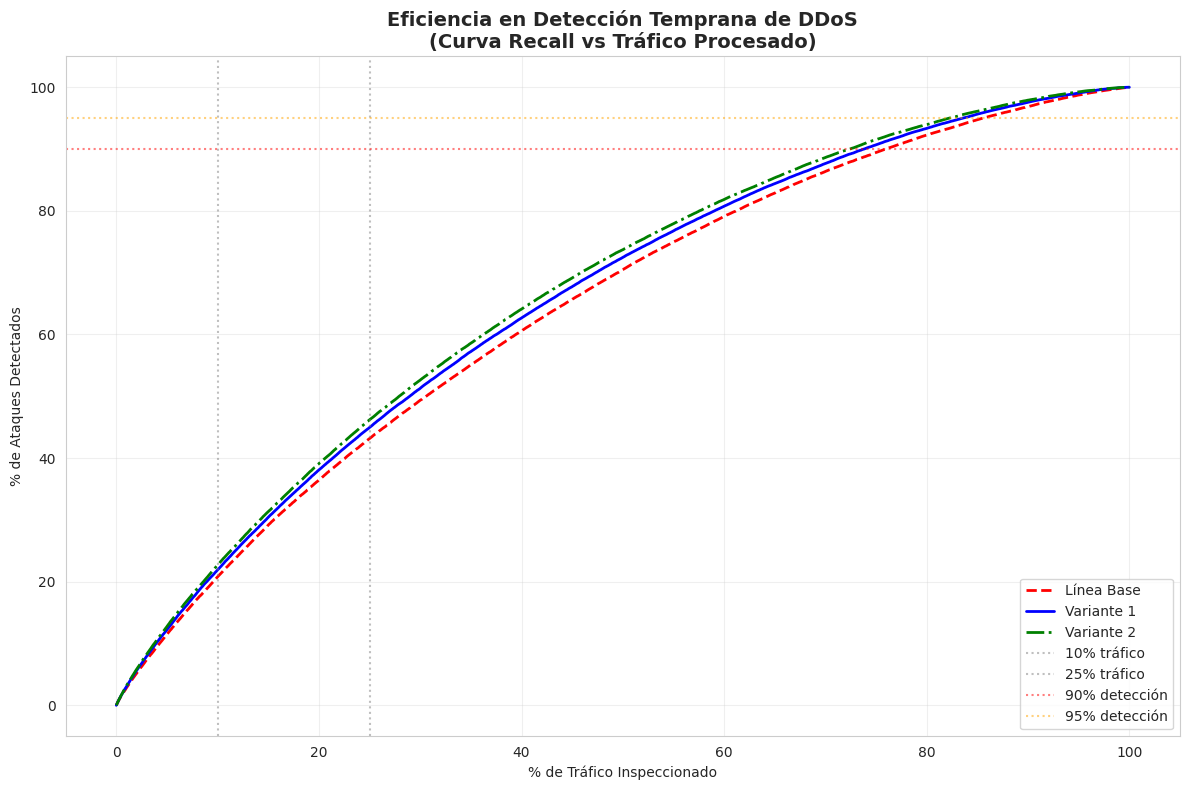

In [30]:
plt.figure(figsize=(12, 8))

for probs, model_name, color, linestyle in [
    (y_prob_base, 'Línea Base', 'red', '--'),
    (y_prob_var1, 'Variante 1', 'blue', '-'),
    (y_prob_var2, 'Variante 2', 'green', '-.')
]:
    # Ordenar muestras por probabilidad descendente
    sorted_indices = np.argsort(probs)[::-1]
    sorted_labels = y_test[sorted_indices]
    
    # Calcular recall acumulado
    cumulative_attacks = np.cumsum(sorted_labels == 1)
    total_attacks = np.sum(y_test == 1)
    recall_at_k = cumulative_attacks / total_attacks
    
    # Porcentaje de tráfico inspeccionado
    traffic_inspected = np.arange(1, len(recall_at_k) + 1) / len(recall_at_k)
    
    plt.plot(traffic_inspected * 100, recall_at_k * 100, 
             label=model_name, color=color, linestyle=linestyle, linewidth=2)

plt.xlabel('% de Tráfico Inspeccionado')
plt.ylabel('% de Ataques Detectados')
plt.title('Eficiencia en Detección Temprana de DDoS\n(Curva Recall vs Tráfico Procesado)', 
          fontweight='bold', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Marcadores clave
plt.axvline(x=10, color='gray', linestyle=':', alpha=0.5, label='10% tráfico')
plt.axvline(x=25, color='gray', linestyle=':', alpha=0.5, label='25% tráfico')
plt.axhline(y=90, color='red', linestyle=':', alpha=0.5, label='90% detección')
plt.axhline(y=95, color='orange', linestyle=':', alpha=0.5, label='95% detección')

plt.legend()
plt.tight_layout()
plt.show()

IMPACTO DE FALSOS POSITIVOS VS FALSOS NEGATIVOS

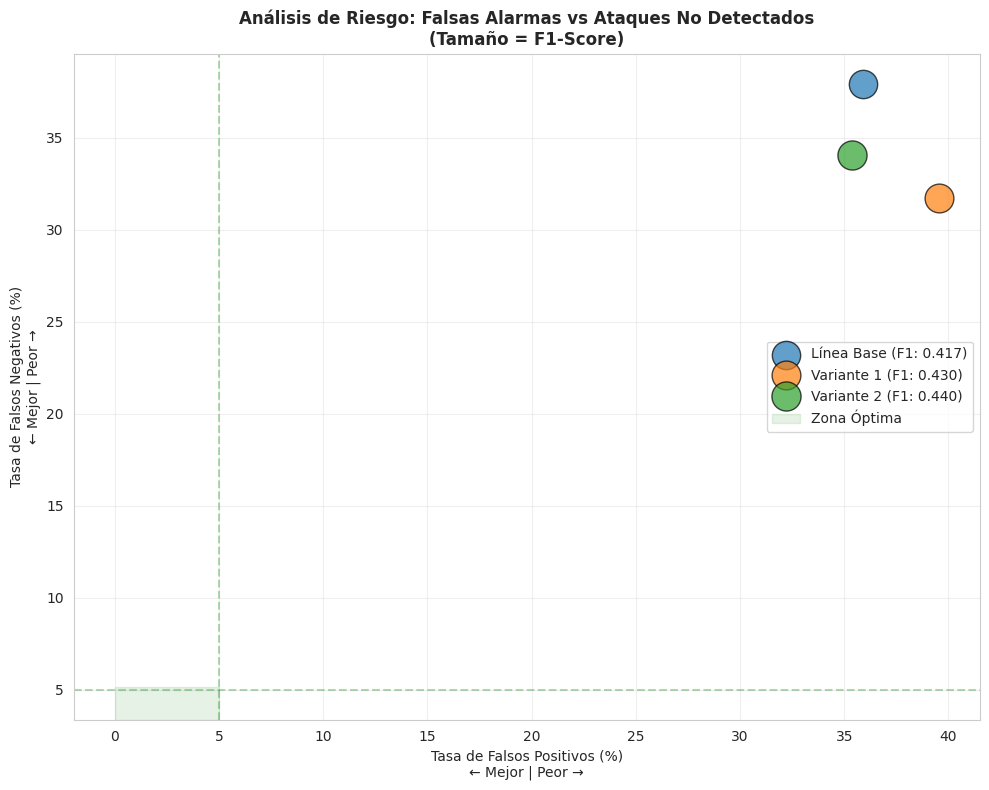

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))

# Calcular FP y FN para cada modelo
fp_fn_data = []
model_names = ['Línea Base', 'Variante 1', 'Variante 2']
predictions = [y_pred_base, y_pred_var1, y_pred_var2]

for i, (y_pred, name) in enumerate(zip(predictions, model_names)):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fp_rate = fp / (fp + tn)  # Falsa alarma
    fn_rate = fn / (fn + tp)  # Ataque no detectado
    
    fp_fn_data.append((fp_rate, fn_rate, name))

# Scatter plot con burbujas proporcionales al F1-Score
f1_scores = [report_base['1']['f1-score'], report_var1['1']['f1-score'], report_var2['1']['f1-score']]
sizes = [score * 1000 for score in f1_scores]  # Tamaño proporcional al F1-Score

for i, (fp_rate, fn_rate, name) in enumerate(fp_fn_data):
    ax.scatter(fp_rate * 100, fn_rate * 100, s=sizes[i], alpha=0.7, 
               label=f'{name} (F1: {f1_scores[i]:.3f})', edgecolors='black')

ax.set_xlabel('Tasa de Falsos Positivos (%)\n← Mejor | Peor →')
ax.set_ylabel('Tasa de Falsos Negativos (%)\n← Mejor | Peor →')
ax.set_title('Análisis de Riesgo: Falsas Alarmas vs Ataques No Detectados\n(Tamaño = F1-Score)', 
             fontweight='bold', fontsize=12)

# Área óptima (esquina inferior izquierda)
ax.axvspan(0, 5, ymin=0, ymax=0.05, alpha=0.1, color='green', label='Zona Óptima')
ax.axhline(y=5, color='green', linestyle='--', alpha=0.3)
ax.axvline(x=5, color='green', linestyle='--', alpha=0.3)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ENDIMIENTO VS EFICIENCIA

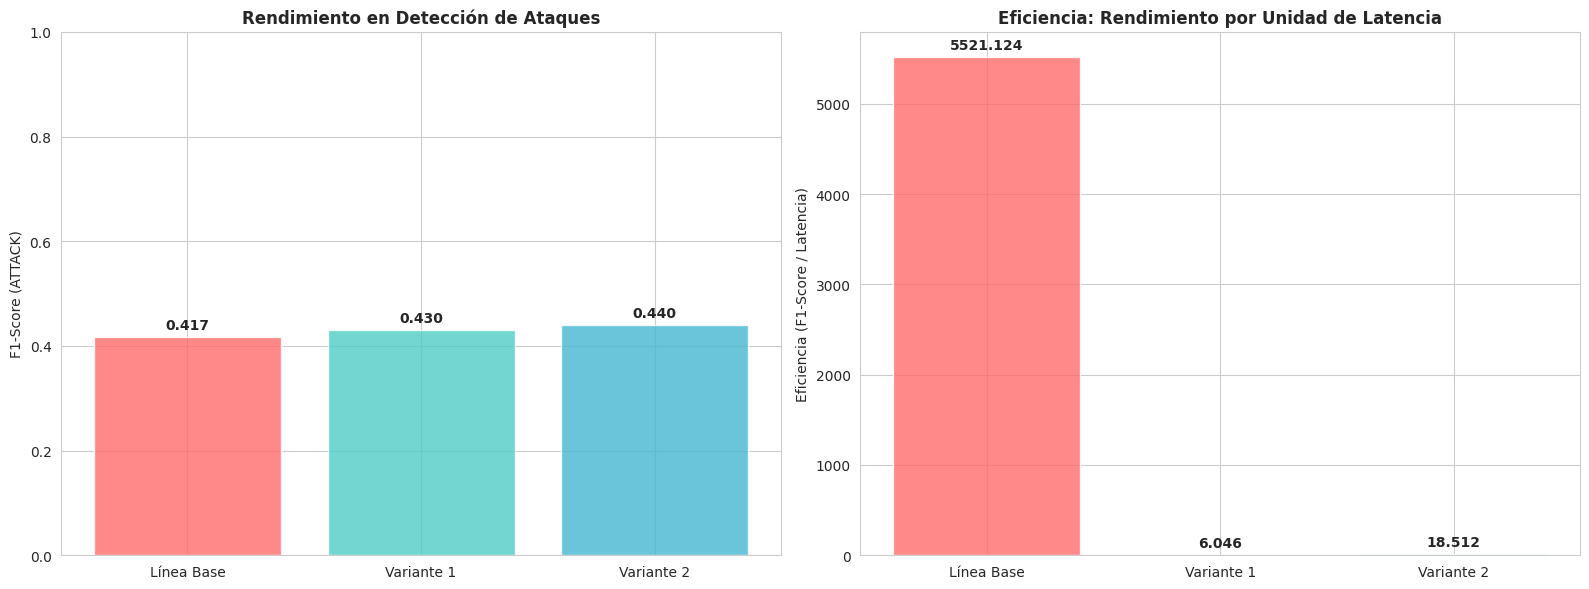

In [33]:
# Crear métrica compuesta (F1-Score normalizado por latencia)
f1_scores = [report_base['1']['f1-score'], report_var1['1']['f1-score'], report_var2['1']['f1-score']]
latencies = [inf_time_base * 1000, inf_time_var1 * 1000, inf_time_var2 * 1000]  # ms
efficiency_scores = [f1 / lat for f1, lat in zip(f1_scores, latencies)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Rendimiento puro
bars1 = ax1.bar(model_names, f1_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
ax1.set_ylabel('F1-Score (ATTACK)')
ax1.set_title('Rendimiento en Detección de Ataques', fontweight='bold')
ax1.set_ylim(0, 1)
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# Gráfico 2: Eficiencia (rendimiento/latencia)
bars2 = ax2.bar(model_names, efficiency_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
ax2.set_ylabel('Eficiencia (F1-Score / Latencia)')
ax2.set_title('Eficiencia: Rendimiento por Unidad de Latencia', fontweight='bold')
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + max(efficiency_scores)*0.01,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

ANÁLISIS DE CONFIANZA EN LAS PREDICCIONES

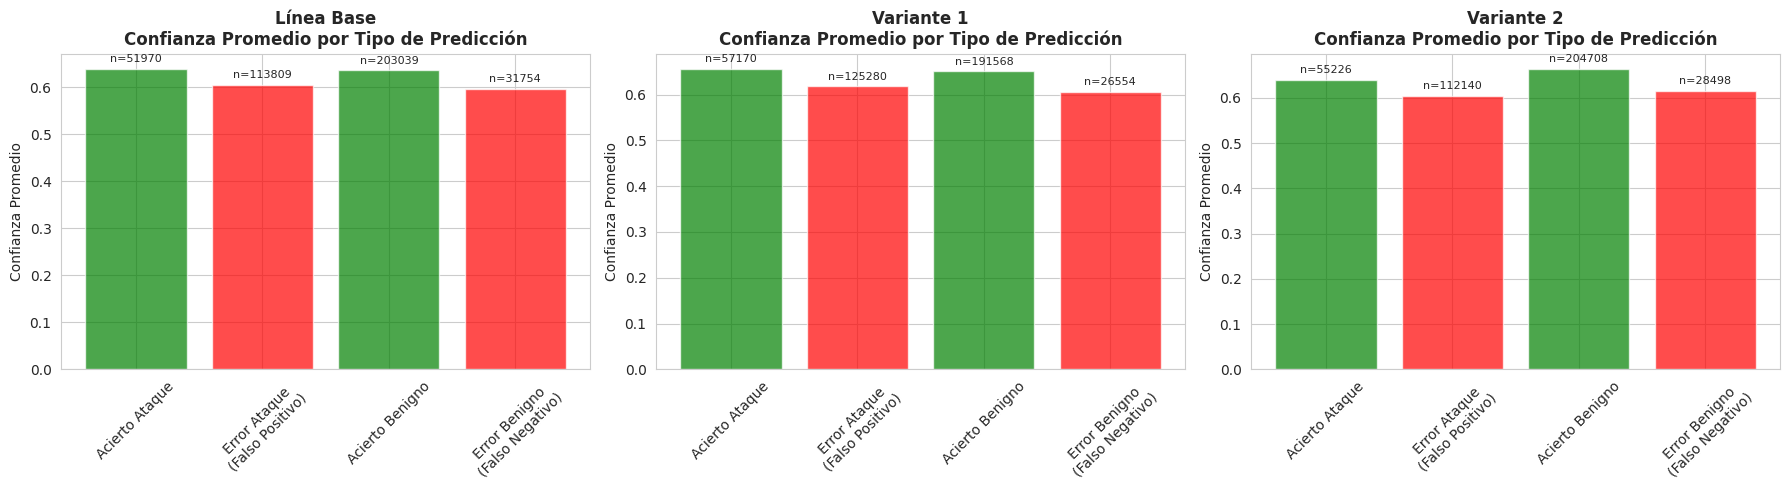

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (probs, preds, model_name) in enumerate([
    (y_prob_base, y_pred_base, 'Línea Base'),
    (y_prob_var1, y_pred_var1, 'Variante 1'),
    (y_prob_var2, y_pred_var2, 'Variante 2')
]):
    # Calcular confianza promedio por tipo de predicción
    correct_attack = probs[(y_test == 1) & (preds == 1)]
    incorrect_attack = probs[(y_test == 0) & (preds == 1)]
    correct_benign = 1 - probs[(y_test == 0) & (preds == 0)]
    incorrect_benign = 1 - probs[(y_test == 1) & (preds == 0)]
    
    categories = ['Acierto Ataque', 'Error Ataque\n(Falso Positivo)', 
                  'Acierto Benigno', 'Error Benigno\n(Falso Negativo)']
    confidences = [
        np.mean(correct_attack) if len(correct_attack) > 0 else 0,
        np.mean(incorrect_attack) if len(incorrect_attack) > 0 else 0,
        np.mean(correct_benign) if len(correct_benign) > 0 else 0,
        np.mean(incorrect_benign) if len(incorrect_benign) > 0 else 0
    ]
    counts = [len(correct_attack), len(incorrect_attack), 
              len(correct_benign), len(incorrect_benign)]
    
    bars = axes[idx].bar(categories, confidences, color=['green', 'red', 'green', 'red'], alpha=0.7)
    axes[idx].set_title(f'{model_name}\nConfianza Promedio por Tipo de Predicción', fontweight='bold')
    axes[idx].set_ylabel('Confianza Promedio')
    axes[idx].tick_params(axis='x', rotation=45)
    
    # Añadir conteos
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                      f'n={count}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

Matriz de Decisión

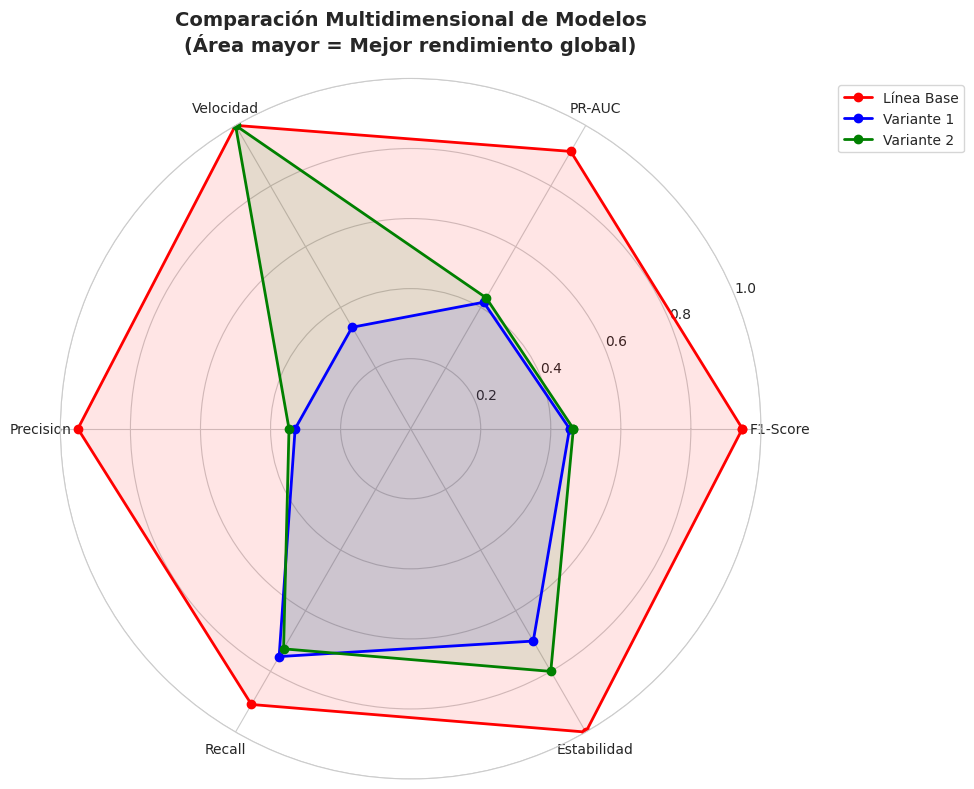

In [35]:
criteria = ['F1-Score', 'PR-AUC', 'Velocidad', 'Precision', 'Recall', 'Estabilidad']
models_data = {
    'Línea Base': [f1_scores[0], pr_auc_base, 1/latencies[0], 
                   report_base['1']['precision'], report_base['1']['recall'], 0.9],
    'Variante 1': [f1_scores[1], pr_auc_var1, 1/latencies[1],
                   report_var1['1']['precision'], report_var1['1']['recall'], 0.7],
    'Variante 2': [f1_scores[2], pr_auc_var2, 1/latencies[2],
                   report_var2['1']['precision'], report_var2['1']['recall'], 0.8]
}

# Normalizar datos (0-1)
for key in models_data:
    models_data[key] = [x / max([models_data[m][i] for m in models_data]) 
                       for i, x in enumerate(models_data[key])]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
angles = np.linspace(0, 2*np.pi, len(criteria), endpoint=False).tolist()
angles += angles[:1]  # Cerrar el círculo

for model_name, color in [('Línea Base', 'red'), ('Variante 1', 'blue'), ('Variante 2', 'green')]:
    values = models_data[model_name]
    values += values[:1]  # Cerrar el círculo
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=color)
    ax.fill(angles, values, alpha=0.1, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(criteria)
ax.set_ylim(0, 1)
ax.set_title('Comparación Multidimensional de Modelos\n(Área mayor = Mejor rendimiento global)', 
             fontweight='bold', fontsize=14, pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.tight_layout()
plt.show()

## 5. Validación y Sanidad
- **Split Estratificado:** Proporción de clases mantenida
- **Sin Leakage:** Scaler ajustado solo con training
- **Seeds Fijos:** random_state=42 para reproducibilidad
- **Evaluación Consistente:** Mismas métricas para todos

## 6. Conclusión y Decisión

In [28]:
f1_scores = {
    'Línea Base': report_base['1']['f1-score'],
    'Variante 1': report_var1['1']['f1-score'], 
    'Variante 2': report_var2['1']['f1-score']
}

best_model_name = max(f1_scores, key=f1_scores.get)

## 7. Reproducibilidad

In [ ]:
# Guardar artefactos
checkpoint_dir = Path("checkpoints")
checkpoint_dir.mkdir(exist_ok=True)

print(f"\nGUARDANDO ARTEFACTOS EN: {checkpoint_dir.absolute()}")

# Guardar scaler y modelo seleccionado
joblib.dump(scaler, checkpoint_dir / "scaler.pkl")

if best_model_name == 'Variante 1':
    encoder.save(checkpoint_dir / "encoder.keras")
    cnn_lstm_model.save(checkpoint_dir / "classifier.keras")
    print("Autoencoder + CNN-LSTM guardado")
elif best_model_name == 'Variante 2':
    mlp_model.save(checkpoint_dir / "mlp_classifier.keras")
    print("MLP guardado")
else:
    joblib.dump(baseline_model, checkpoint_dir / "logistic_regression.pkl")
    print("Regresión Logística guardada")

# Guardar resultados
df_results.to_csv(checkpoint_dir / "model_comparison_results.csv", index=False)
print("Resultados comparativos guardados")

print(f"\nESTRUCTURA DE ARTEFACTOS:")
for file in checkpoint_dir.glob("*"):
    print(f"   • {file.name}")


- **Comandos para Correr (README):**
    1.  Asegurarse de tener el dataset `dataset_final.csv` en la carpeta `../dataset/`.
    2.  Instalar las dependencias (`pip install -r requirements.txt`).
    3.  Ejecutar este script o notebook.

**Ubicación de Artefactos:** Los modelos finales y el scaler se guardan en la carpeta `./checkpoints/`.